### Setup

In [1]:
import xarray as xr
from pathlib import Path
import numpy as np
import scipy
import yaml
import matplotlib.pyplot as plt
from matplotlib import colormaps


### set these variables
config_str = "/glade/work/jmelms/data/dcmip2025_idealized_tests/experiments/long_sim_0/config.yml"
cmap_str = "viridis" # options here: matplotlib.org/stable/tutorials/colors/colormaps.html
cmap = colormaps.get_cmap(cmap_str)

### the rest should work itself out
### except for the plot settings at the end
config_path = Path(config_str)
assert config_path.exists(), f"Config file does not exist @ {config_path}"
print(f"Config file exists @ {config_path}")
# import config file
with open(config_path, "r") as stream:
    config = yaml.safe_load(stream)

ic_params = config["initial_condition_parameters"]
keys, val_pairs = zip(*ic_params.items())
vals, units = zip(*val_pairs)
param_val_pairs = dict(zip(keys, vals))
val_types = [isinstance(v, list) for v in vals]
exp_param_idx = val_types.index(
    1
)  # this is the parameter that was varied in the experiment
exp_param = keys[exp_param_idx]
exp_vals = np.array(vals[exp_param_idx])
exp_param_units = units[exp_param_idx]
assert sum(val_types) == 1, "Only one experimental parameter allowed"

exp_dir = (
    Path(config["experiment_dir"]) / config["experiment_name"]
)  # all data for experiment stored here
ic_nc_dir = exp_dir / "ic_nc"  # contains processed ICs in nc format
data_path = exp_dir / "output.nc"  # where output from inference is saved

nt = config["inference_parameters"]["n_steps"]
dt = 6  # hours. all experiments have this timestep
n_expvar = len(exp_vals)
ne = 1  # no ensemble feature has been implemented yet
ensemble_colors = cmap(np.linspace(0, 1, n_expvar))
units_table = {
    "VAR_2T": "K",
    "VAR_10U": "m/s",
    "VAR_10V": "m/s",
    "VAR_100U": "m/s",
    "VAR_100V": "m/s",
    "VAR_500T": "K",
    "T": "K",
    "U": "m/s",
    "V": "m/s",
    "Z": "m",
    "R": "%",
    "SP": "hPa",
    "MSL": "hPa",
    "TCW": "kg/m^2",
    "Q": "kg/kg",
    "total_energy": "J/m^2",
    "lw_te": "J/m^2",
    "dte_dt": "W/m^2",
}

# define consts
cp = 1005.0  # J/kg/K
g = 9.81  # m/s^2j
Lv = 2.26e6  # J/kg

print(f"Loading data from {data_path}")
print(f"Iter var {exp_param} = {exp_vals} {exp_param_units}")

Config file exists @ /glade/work/jmelms/data/dcmip2025_idealized_tests/experiments/long_sim_0/config.yml
Loading data from /glade/work/jmelms/data/dcmip2025_idealized_tests/experiments/long_sim_0/output.nc
Iter var zt0 = [283 288 293] K


### Load and Process Data

In [2]:
# load dataset -- this might be very large, so be careful
ds = xr.open_dataset(data_path).isel(ensemble=0)  # data only has one member

# convert SP and MSL from Pa to hPa
ds["SP"] = ds["SP"] / 100
ds["MSL"] = ds["MSL"] / 100

# convert Z geopotential to geopotential height
ds["Z"] = ds["Z"] / g

# reset time coordinate
time_hours = (ds.time - ds.time[0]) / np.timedelta64(
    1, "h"
)  # set time coord relative to start time
ds.update({"time": time_hours})
ds = ds.assign_attrs({"time units": "hours since start"})

### calculate some latitude-weighted global mean quantities
def latitude_weighted_mean(da, latitudes):
    """
    Calculate the latitude weighted mean of a variable in a dataset
    """
    lat_radians = np.deg2rad(latitudes)
    weights = np.cos(lat_radians)
    weights.name = "weights"
    var_weighted = da.weighted(weights)
    return var_weighted.mean(dim=["latitude", "longitude"])

ds["mean_VAR_2T"] = latitude_weighted_mean(ds["VAR_2T"], ds.latitude)
ds["mean_T"] = latitude_weighted_mean(ds["T"], ds.latitude)
ds["mean_SP"] = latitude_weighted_mean(ds["SP"], ds.latitude)

### Calculate total energy
# This is a bit tricky because we need to integrate over pressure levels
# and we need to account for the fact that the some pressure levels
# are not valid due to the surface pressure being lower than the pressure level

# Create a mask for valid levels
# get dict of all dims but level to expand along
sp = ds["SP"]
sp_expanded = sp.expand_dims(dim={"level": ds.sizes["level"]}, axis=-1)
expand_dict = {dim: ds.sizes[dim] for dim in ds.dims if dim != "level"}
levs_expanded = ds["level"].expand_dims(dim=expand_dict)
mask = levs_expanded <= sp_expanded

# get pressure
pa = 100 * ds.level.values # convert to Pa from hPa, used for integration

### Calc pointwise total energy ###

# sensible heat
sensible_heat = cp * ds["T"]
# latent heat - this is already column-integrated
latent_heat = Lv * ds["TCW"]
# geopotential energy
geopotential_energy = g * ds["Z"]
# kinetic energy
kinetic_energy = 0.5 * ds["U"] ** 2 + 0.5 * ds["V"] ** 2

# total energy minus latent heat
dry_total_energy = sensible_heat + geopotential_energy + kinetic_energy
dry_total_energy = dry_total_energy.where(mask, np.nan)
# column integration
dry_total_energy_column = (1 / g) * scipy.integrate.trapezoid(
    dry_total_energy, pa, axis=2
)
# sum
ds["total_energy"] = (expand_dict, dry_total_energy_column + latent_heat.values)
ds["total_energy"] = ds["total_energy"].assign_attrs(
    {"units": "J/m^2", "long_name": "Total Energy"}
)
# get latitude weighted total energy (time, ensemble)
ds["lw_te"] = latitude_weighted_mean(ds["total_energy"], ds.latitude)
ds["lw_te"].assign_attrs(
    {"units": "J/m^2", "long_name": "Latitude-Weighted Total Energy"}
)
# use second order central difference to calculate the time derivative
# this computes time derivative w/r/t hours, so divide by 3600 to get W/m^2
ds["dte_dt"] = ds["lw_te"].differentiate("time") / 3600
ds["dte_dt"].assign_attrs(
    {"units": "W/m^2", "long_name": "Time Derivative of Latitude-Weighted Total Energy"}
)
ds

<xarray.Dataset> Size: 184GB
Dimensions:       (zt0: 3, time: 200, latitude: 721, longitude: 1440, level: 13)
Coordinates:
  * time          (time) float64 2kB 0.0 6.0 12.0 ... 1.188e+03 1.194e+03
  * level         (level) int64 104B 50 100 150 200 250 ... 600 700 850 925 1000
  * latitude      (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude     (longitude) float64 12kB 0.0 0.2502 0.5003 ... 359.7 360.0
    ensemble      int64 8B 0
  * zt0           (zt0) int64 24B 283 288 293
Data variables: (12/19)
    VAR_10U       (zt0, time, latitude, longitude) float32 2GB ...
    VAR_10V       (zt0, time, latitude, longitude) float32 2GB ...
    VAR_100U      (zt0, time, latitude, longitude) float32 2GB ...
    VAR_100V      (zt0, time, latitude, longitude) float32 2GB ...
    VAR_2T        (zt0, time, latitude, longitude) float32 2GB 255.1 ... 274.7
    SP            (zt0, time, latitude, longitude) float32 2GB 1.013e+03 ... ...
    ...            ...
    mean_VAR_2T   (zt0, time) float64 5kB 281.7 282.4 283.3 ... 286.9 286.6
    mean_T        (zt0, time, level) float64 62kB 182.2 201.6 ... 283.0 286.8
    mean_SP       (zt0, time) float64 5kB 1.013e+03 1.013e+03 ... 1.003e+03
    total_energy  (zt0, time, latitude, longitude) float32 2GB 2.875e+09 ... ...
    lw_te         (zt0, time) float64 5kB 3.095e+09 3.096e+09 ... 3.143e+09
    dte_dt        (zt0, time) float64 5kB 32.01 80.02 122.1 ... -44.99 -88.74
Attributes:
    zt0 units:   K
    time units:  hours since start

### Calculate Effective Radiative Temperature

We know 

$$
\frac{\partial E_T}{\partial t} = \overline{\text{{ISR}}} - \overline{\text{{OLR}}} \to \overline{\text{{OLR}}} = \overline{\text{{ISR}}} - \frac{\partial E_T}{\partial t}
$$

We can use this to find the effective radiative temperature 

$$
\overline{T_e} = (\overline{\text{{OLR}}} / \sigma)^\frac{1}{4} = ((\overline{\text{{ISR}}} - \frac{\partial E_T}{\partial t}) / \sigma)^\frac{1}{4}
$$

We will compare $\overline{T_e}$ to the closest value in the model run, which should be roughly 500 hPa temperatures (or the point at which the atmospheric optical thickness equals 1). The trend is the important part; it's alright if they're off by some constant factor, as long as they show the same pattern of development. Otherwise, temperature does not seem to be driving radiation, which is unusual. 

In [3]:
insolation = 1320 # W/m^2
albedo = 0.3 # percent of light reflected
sigma = 5.67e-8 # Stefan-Boltzmann constant, W/m^2/K^4
areal_avg = insolation / 4 # from disc to sphere
ISR = areal_avg * (1 - albedo) # absorbed solar radiation
olr = ISR - ds["dte_dt"] # outgoing longwave radiation
ds["olr"] = olr
ds["olr"].assign_attrs(
    {"units": "W/m^2", "long_name": "Outgoing Longwave Radiation"}
)
effective_rad_temp = (olr / 5.67e-8) ** 0.25 # effective radiative temperature
ds["effective_rad_temp"] = effective_rad_temp
ds["effective_rad_temp"].assign_attrs(
    {"units": "K", "long_name": "Effective Radiative Temperature"}
)

<xarray.DataArray 'effective_rad_temp' (zt0: 3, time: 200)> Size: 5kB
array([[243.39528395, 227.16002039, 209.34752563, 214.2452067 ,
        217.77331454, 225.25943988, 236.1827839 , 242.93097639,
        244.38752917, 246.01316922, 251.05700595, 254.2403326 ,
        252.89525249, 252.03464809, 253.35634375, 253.41254796,
        253.3833915 , 254.37080002, 249.99511709, 246.86524037,
        251.71899664, 250.44139685, 243.29678761, 242.58058321,
        255.74016274, 254.35358169, 239.29453316, 235.2663932 ,
        244.9759338 , 248.39697647, 232.1045399 , 226.19377272,
        246.23140453, 255.86985627, 244.73241725, 235.0694461 ,
        244.91464203, 249.86839678, 238.81019744, 231.88811211,
        242.60987283, 247.08555696, 240.75623803, 235.29237113,
        249.07841091, 255.06285983, 245.1032197 , 240.66858029,
        251.04851007, 255.52762466, 241.34178503, 236.78838132,
        250.98566147, 259.67005679, 246.43443935, 228.301028  ,
        227.2061471 , 238.52957816, 238.63871381, 229.49188487,
        240.58301441, 249.6846397 , 245.28982865, 242.99625597,
        252.42152298, 257.51825177, 252.1094018 , 251.17863046,
        253.87560161, 248.71005004, 238.15039649, 232.50786887,
        232.93521651, 239.41023953, 239.36586068, 237.53184209,
        241.24387898, 247.0147058 , 244.34303215, 240.97808069,
...
        246.92737866, 256.23290303, 263.55300105, 256.63748217,
        253.18827336, 263.18592851, 267.63244019, 254.74454972,
        249.45588934, 260.15073451, 268.20844313, 256.36602255,
        245.62230951, 253.65675883, 257.55872457, 245.03946239,
        235.31509784, 251.87680574, 264.51591073, 261.5486248 ,
        256.98387287, 263.77221518, 270.14302142, 261.27011138,
        250.07217332, 252.96407737, 261.43363368, 256.91815573,
        248.03533729, 252.34947897, 259.36250534, 251.36343586,
        245.50927538, 250.21042233, 260.1803264 , 251.16003354,
        231.40707283, 222.15167557, 237.49528552, 246.2708507 ,
        244.99224318, 254.47664824, 264.97700552, 264.88635489,
        262.41293784, 265.85177896, 268.88352358, 264.12289182,
        259.43175148, 265.81653385, 276.56739615, 272.75926139,
        263.53263142, 267.26746357, 273.04360902, 263.49635373,
        252.92477737, 258.09549186, 263.22951672, 251.95672715,
        241.19060737, 249.92998676, 257.46510857, 250.25624193,
        240.15320388, 254.15764462, 265.12187911, 258.26896384,
        245.92301851, 251.1134883 , 254.14588542, 243.40609307,
        236.78721013, 243.07225953, 254.0966404 , 257.13008899,
        253.79236141, 258.08730522, 264.13557269, 274.03292343]])
Coordinates:
  * time      (time) float64 2kB 0.0 6.0 12.0 ... 1.182e+03 1.188e+03 1.194e+03
    ensemble  int64 8B 0
  * zt0       (zt0) int64 24B 283 288 293
Attributes:
    units:      K
    long_name:  Effective Radiative Temperature

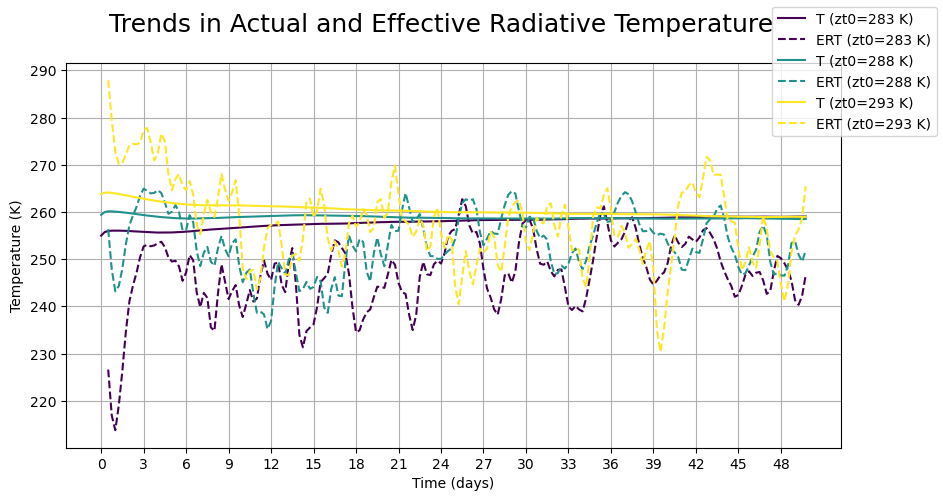

In [13]:
ds["mean_VAR_500T"] = ds["mean_T"].sel(level=500)
fig, ax = plt.subplots(figsize=(10, 5))
for j, val in enumerate(ds[exp_param].values):
    ax.plot(
        time_hours,
        ds["mean_VAR_500T"].sel({exp_param: val}),
        label=f"T ({exp_param}={val} {exp_param_units})",
        color=ensemble_colors[j],
        )
    # change to smoothed line
    smoothed_ERT = ds["effective_rad_temp"].sel({exp_param: val}).rolling(time=3).mean()
    ax.plot(
        time_hours,
        smoothed_ERT,
        label=f"ERT ({exp_param}={val} {exp_param_units})",
        color=ensemble_colors[j],
        linestyle="--",
        )
    # ax.plot(
    #     time_hours,
    #     ds["effective_rad_temp"].sel({exp_param: val}),
    #     label=f"ERT ({exp_param}={val} {exp_param_units})",
    #     color=ensemble_colors[j],
    #     linestyle="--",
    #     )
ax.set_xticks(time_hours[::12], (time_hours[::12] / 24).values.astype(int))
ax.set_xlabel("Time (days)")
ax.set_ylabel(f"Temperature (K)")
fig.suptitle("Trends in Actual and Effective Radiative Temperature", fontsize=18)
fig.legend()
ax.grid()
plt.show()

### Plot the Results

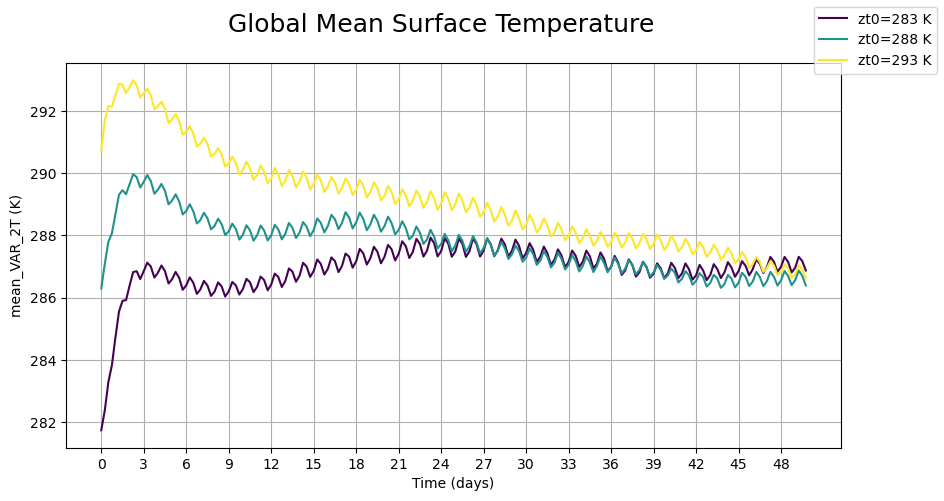

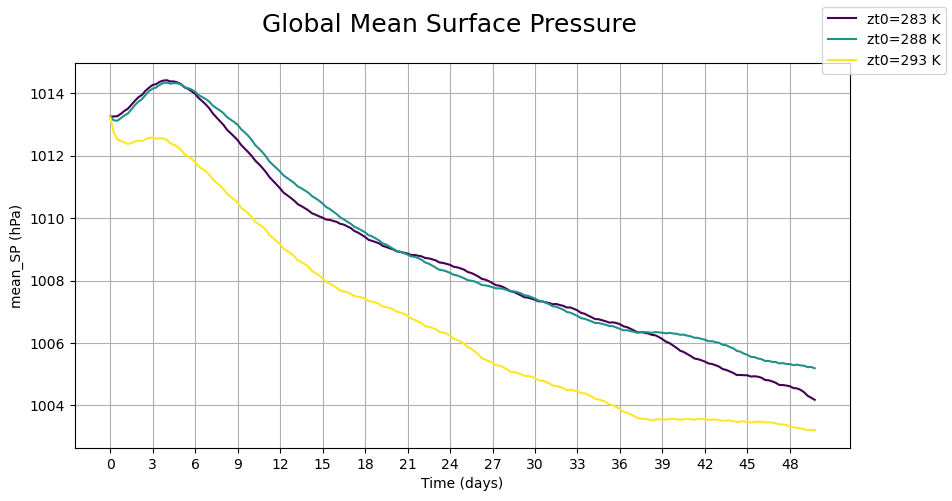

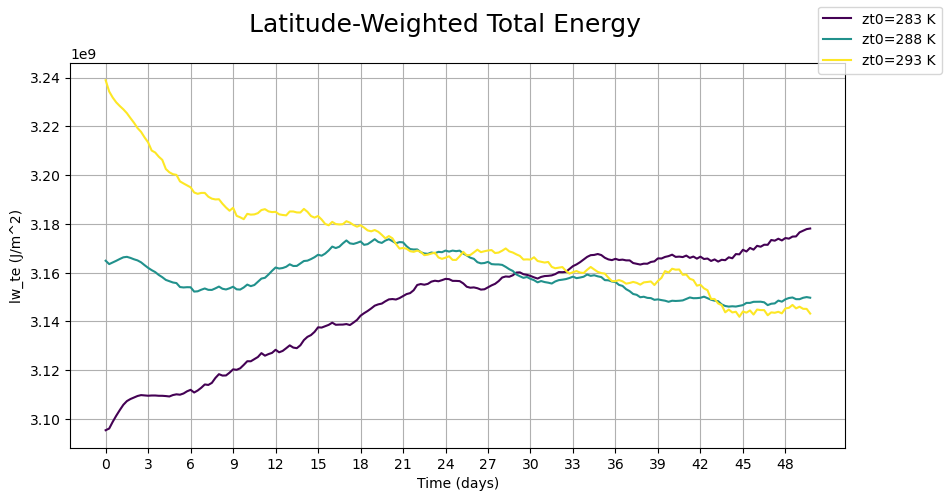

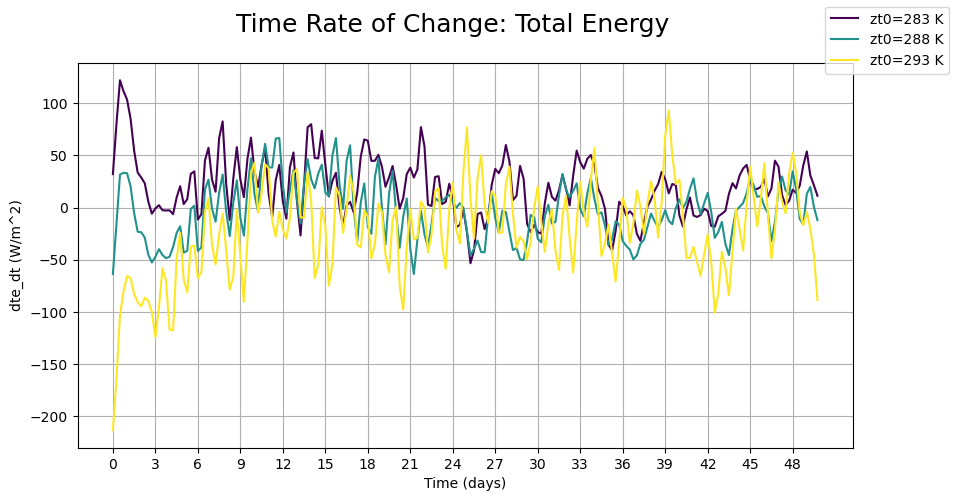

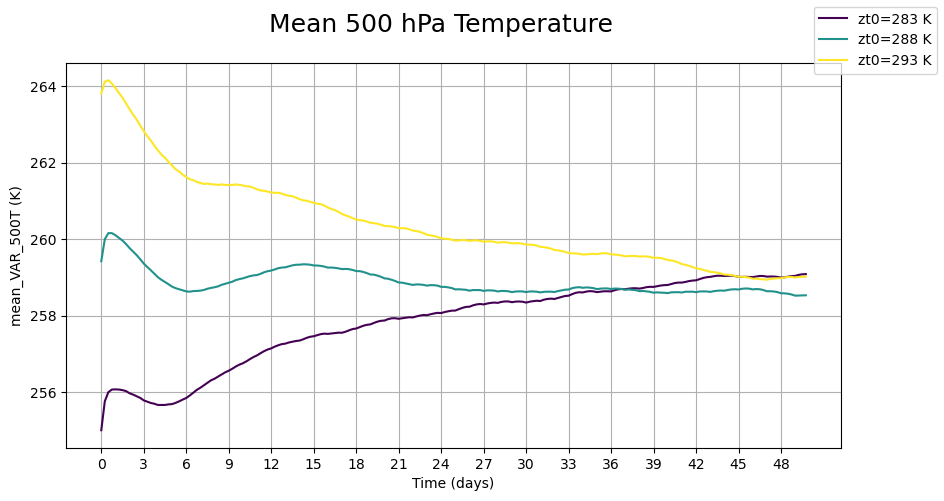

In [ ]:
# Plot the results
plot_vars = ["mean_VAR_2T", "mean_SP", "lw_te", "dte_dt"]
titles = ["Global Mean Surface Temperature", "Global Mean Surface Pressure", "Latitude-Weighted Total Energy", "Time Rate of Change: Total Energy", "Mean 500 hPa Temperature"]

for i, pvar in enumerate(plot_vars):
    fig, ax = plt.subplots(figsize=(10, 5))
    data = ds[pvar]
    # if pvar == "mean_VAR_2T":
    #     # plot the diurnal cycle
    #     diurnal_temp = 0.5*np.sin(2 * np.pi * time_hours / 24) + ds["mean_VAR_2T"].mean().values
    #     ax.plot(time_hours, diurnal_temp, label="Diurnal Cycle", color="black", linestyle="--")
    for j, val in enumerate(ds[exp_param].values):
        ax.plot(
            time_hours,
            data.sel({exp_param: val}),
            label=f"{exp_param}={val} {exp_param_units}",
            color=ensemble_colors[j],
        )

    ax.set_xticks(time_hours[::12], (time_hours[::12] / 24).values.astype(int))
    ax.set_xlabel("Time (days)")
    ax.set_ylabel(f"{pvar} ({units_table[pvar.lstrip('mean_')]})")
    fig.suptitle(titles[i], fontsize=18)
    fig.legend()
    ax.grid()
plt.show()

### Plot for Crossroads 2025 Poster

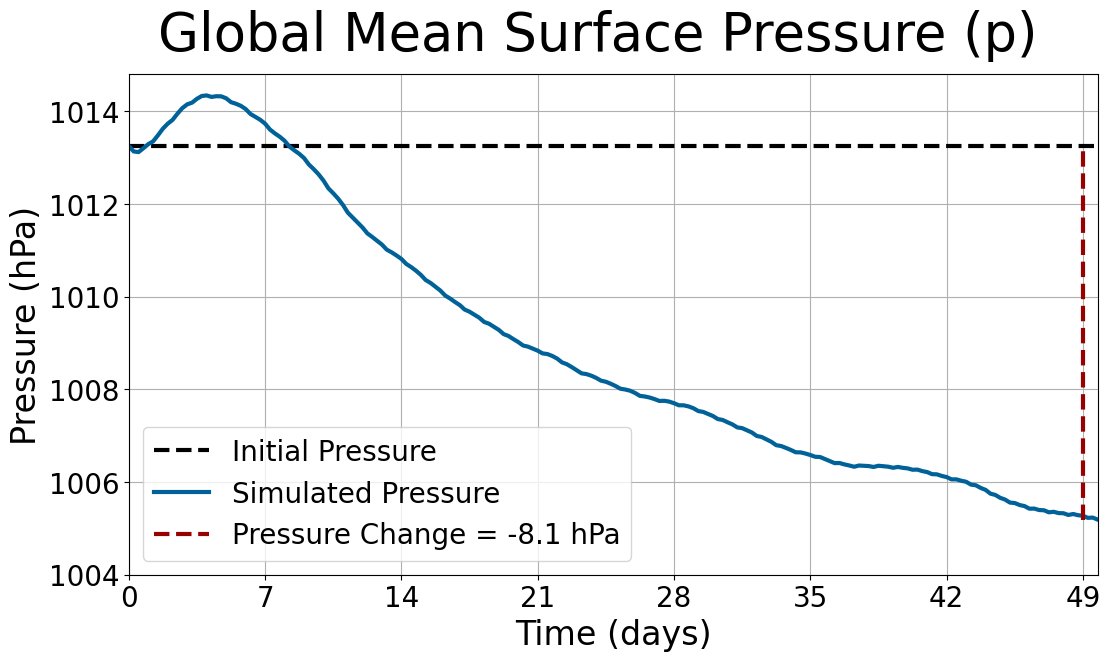

In [51]:
# Plot the results
plot_var = "mean_SP"
title = "Global Mean Surface Pressure (p)"
line_col = "#990000"
linewidth = 3
fontsize = 24
smallsize = 20
fig, ax = plt.subplots(figsize=(12.5, 6.5))
data = ds[plot_var]
ax.hlines(xmin=0, xmax=time_hours[-1], y=data.isel(zt0=1, time=0).mean(), color="black", linestyle="--", label="Initial Pressure", linewidth=linewidth)
ax.plot(
        time_hours,
        data.isel({exp_param: 1}),
        color="#006298",
        linewidth = linewidth,
        label="Simulated Pressure",
    )
t = time_hours[::28][-1]
p = data.isel({exp_param: 1})
p0 = p.isel(time=0).mean()
p1 = p.isel(time=-1).mean()
p_diff = p1 - p0
p_diff_str = f"{p_diff.values:.1f} hPa"

ax.vlines(x=t, ymin=p1, ymax=p0, color=line_col, linestyle="--", label=fr"Pressure Change = {p_diff_str}", linewidth=linewidth)

ax.set_xticks(time_hours[::28], (time_hours[::28] / 24).values.astype(int), fontsize=smallsize)
yticks = np.arange(1004, 1016, 2)
ax.set_yticks(yticks, yticks, fontsize=smallsize)
ax.set_xlabel("Time (days)", fontsize=fontsize)
ax.set_ylabel("Pressure (hPa)", fontsize=fontsize)
ax.set_xlim(xmin=0, xmax=time_hours[-1])
fig.suptitle(title, fontsize=38)
ax.grid()
ax.set_facecolor("#ffffff")
plt.legend(fontsize=smallsize, loc="lower left")
plt.savefig(f"{title}.png", dpi=300, bbox_inches="tight")

### Climate Dynamics Project
Hypothesis: 

When initialized with an aquaplanetary atmospheric profile in both hydrostatic and gradient wind balance, but a latitude-weighted mean surface temperature higher (lower) than our current value of 288 K, the model, FourCastNet, will show the atmosphere cooling (warming) at a rate consistent with current solar insolation and the Planck feedback.

**Step One**: Calculate Planck cooling rate

In [6]:
output_ds = ds[plot_vars]
output_ds.to_netcdf(exp_dir / "output_processed.nc")
print(f"Saved processed output to {exp_dir / 'output_processed.nc'}")

Saved processed output to /glade/work/jmelms/data/dcmip2025_idealized_tests/experiments/long_sim_0/output_processed.nc


### test code for masking routine

In [63]:
tiny_ds = ds.isel(latitude=slice(0, 10), longitude=slice(0, 10), time=slice(0, 10), zt0=0)
sp = tiny_ds["SP"]
t = tiny_ds["T"]
sp_expanded = sp.expand_dims(dim={"level": ds.sizes["level"]}, axis=-1)

# Create a mask for valid levels
levs_expanded = tiny_ds["level"].expand_dims(dim={"latitude": tiny_ds.sizes["latitude"], "longitude": tiny_ds.sizes["longitude"], "time": tiny_ds.sizes["time"]})
mask = levs_expanded <= sp_expanded

# Apply mask
new_t = t.where(mask, np.nan)
levs_expanded.shape, sp_expanded.shape, mask.shape, t.shape, new_t.shape
# print an example of one column, including the mask and lev/sp values
print("Masked temperature")
print(new_t.isel(latitude=3, longitude=3, time=3))
print("Mask")
print(mask.isel(latitude=3, longitude=3, time=3))
print("SP")
print(sp.isel(latitude=3, longitude=3, time=3))
print("levs")
print(tiny_ds["level"])

Masked temperature
<xarray.DataArray 'T' (level: 13)> Size: 52B
array([201.42374, 215.01964, 219.97366, 224.30852, 222.3788 , 220.22012,
       234.07559, 243.13133, 247.84094, 245.94104,       nan,       nan,
             nan], dtype=float32)
Coordinates:
    time       float64 8B 18.0
  * level      (level) int64 104B 50 100 150 200 250 ... 600 700 850 925 1000
    latitude   float64 8B -89.25
    longitude  float64 8B 0.7505
    ensemble   int64 8B 0
    zt0        int64 8B 283
Mask
<xarray.DataArray (level: 13)> Size: 13B
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False])
Coordinates:
  * level      (level) int64 104B 50 100 150 200 250 ... 600 700 850 925 1000
    ensemble   int64 8B 0
    zt0        int64 8B 283
    time       float64 8B 18.0
    latitude   float64 8B -89.25
    longitude  float64 8B 0.7505
SP
<xarray.DataArray 'SP' ()> Size: 4B
array(780.7681, dtype=float32)
Coordinates:
    time       float64 8B 18.0
    la

### Calculate Energetic Input

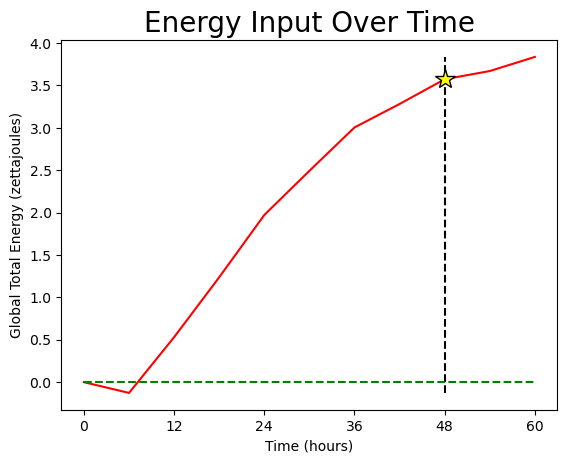

In [ ]:
R = 6.371e6  # m
A = 4 * np.pi * R**2
ens_mem = 283
global_te = gm_te.sel(ensemble=ens_mem) * A
te_delta = global_te - global_te[0]
ted_ZJ = te_delta / 1e21
dat = ted_ZJ
plt.plot(time_hours, dat, color="red")
plt.xticks(time_hours[::2])
plt.xlabel("Time (hours)")
plt.ylabel("Global Total Energy (zettajoules)")
plt.title("Energy Input Over Time", fontsize=20)
plt.vlines(
    time_hours[8], dat.min(), dat.max(), color="black", linestyle="--", label="t=48 hrs"
)
plt.hlines(0, time_hours.min(), time_hours.max(), color="green", linestyle="--")
plt.plot(
    time_hours[8],
    dat[8],
    marker="*",
    markersize=15,
    markeredgecolor="k",
    color="yellow",
    label="t=24 hrs",
)
plt.show()

# Stuff to Fix Later

### Global-Mean Stuve Diagrams

In [ ]:
# # bloomington, IN at 39.5N, 86.5W and denver, CO at 39.5N, 105W
# plot_vars = ["T"]
# # Convert latitude to radians for weighting
# lat_radians = np.deg2rad(ds.latitude)

# # Compute latitude weights using cosine weighting
# weights = np.cos(lat_radians)

# # Normalize weights to sum to 1 over latitude
# weights /= weights.sum()

# # Apply latitude weighting and take the global mean over lat/lon
# atmos_mean_t = (ds["T"] * weights).sum(dim="latitude").mean(dim="longitude")
# var = plot_vars[0]
# plevs = ds.level.values
# lat, lon = (39.5, 360-105.)
# point_ds = ds.sel(latitude=lat, longitude=lon, method="nearest")
# # fig, ax = plt.subplots()
# for t in range(nt):
#     fig, ax = plt.subplots(figsize=(6, 8))
#     for e in range(ne):
#         # dat = point_ds.isel(time=t, ensemble=e)
#         dat = atmos_mean_t.isel(time=t, ensemble=e)
#         v_profile = dat.values
#         ax.plot(v_profile, plevs, label=f"{var}", marker=".", markeredgecolor="black", color=ensemble_colors[e])
#         # sfc_p = dat["SP"].values / 100 # Pa to hPa
#         # ax.hlines(sfc_p, xmin=v_profile.min(), xmax=v_profile.max(), color="red", linestyle="--", label="SP")
#         ax.set_xlabel(f"{var}")
#         ax.set_ylabel("Pressure (hPa)")
#         ax.set_yscale("log")
#         ax.set_yticks(plevs)
#         ax.set_yticklabels(plevs)
#         ax.set_ylim(plevs[-1], plevs[0])
#     xlims = atmos_mean_t.min(), atmos_mean_t.max()
#     ax.set_xlim(*xlims)
#     ax.set_title(f"{var} @ t={t*6} hrs, pos=({lat}N,{lon}W)")
#     fig.savefig(f"/glade/u/home/jmelms/projects/dcmip2025_idealized_tests/analysis/plots/{var}_profile_t{t*6}.png")
#     plt.close(fig)